In [ ]:
!git clone https://github.com/nathanhubens/MultimedIA.git

Cloning into 'MultimedIA'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 193 (delta 63), reused 100 (delta 32), pack-reused 52
Receiving objects: 100% (193/193), 114.37 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
%cd MultimedIA/Lesson\ 3

/content/MultimedIA/Lesson 3


In [ ]:
!pip3 install PyYAML==5.1
!pip install mido==1.2.9
!pip3 install -r requirements.txt
!pip install miditoolkit

     |████████████████████████████████| 274 kB 3.9 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=4a74357bb5e41ef446845c06b6358c53420ad59cc119f43fc72e611a7caa9b2b
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 52 kB 949 kB/s 


In [ ]:
!git clone https://github.com/YatingMusic/MuseMorphose.git

Cloning into 'MuseMorphose'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 78 (delta 29), reused 48 (delta 12), pack-reused 0
Unpacking objects: 100% (78/78), done.


In [5]:
%cd MuseMorphose/

/content/MultimedIA/Lesson 3/MuseMorphose


Download and extract MIDI files dataset

In [6]:
!wget -O remi_dataset.tar.gz https://zenodo.org/record/4782721/files/remi_dataset.tar.gz?download=1
!tar xzvf remi_dataset.tar.gz
!rm remi_dataset.tar.gz

--2021-11-07 18:47:43--  https://zenodo.org/record/4782721/files/remi_dataset.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60167785 (57M) [application/octet-stream]
Saving to: ‘remi_dataset.tar.gz’

remi_dataset.tar.gz 100%[===================>]  57.38M  10.5MB/s    in 7.2s    

2021-11-07 18:47:52 (7.96 MB/s) - ‘remi_dataset.tar.gz’ saved [60167785/60167785]

remi_dataset/
remi_dataset/1000.pkl
remi_dataset/1001.pkl
remi_dataset/1002.pkl
remi_dataset/1003.pkl
remi_dataset/1004.pkl
remi_dataset/1005.pkl
remi_dataset/1006.pkl
remi_dataset/1007.pkl
remi_dataset/1008.pkl
remi_dataset/1009.pkl
remi_dataset/100.pkl
remi_dataset/1010.pkl
remi_dataset/1011.pkl
remi_dataset/1012.pkl
remi_dataset/1013.pkl
remi_dataset/1014.pkl
remi_dataset/1015.pkl
remi_dataset/1016.pkl
remi_dataset/1017.pkl
remi_dataset/1018.pkl
remi_dataset/1019.pkl
remi_dataset

In [7]:
!python3 attributes.py

[rhythm classes] Counter({5: 35456, 1: 29944, 4: 22344, 3: 22298, 0: 21198, 2: 21001, 6: 15834, 7: 15250})
[polyph classes] Counter({2: 27521, 0: 24821, 5: 23600, 6: 22306, 3: 22247, 7: 22170, 4: 21745, 1: 18915})


In [16]:
import sys 
sys.path.append('..')
from midi_converter import check as create_midi_file
from midifile import MidiFile

[preparing data] now at #0
midi_files.mid
<midi file 'midi_files.mid' type 1, 2 tracks, 792 messages>
<midi file 'midi_files.mid' type 1, 2 tracks, 792 messages>
channel 0 start
channel 0 pc 0 time 0 duration 0
on  50 time 0 duration 0 velocity 60
on  58 time 0 duration 0 velocity 68
on  74 time 0 duration 0 velocity 74
on  72 time 0 duration 240 velocity 74
on  36 time 240 duration 240 velocity 0
on  36 time 480 duration 0 velocity 64
on  43 time 480 duration 0 velocity 62
on  50 time 480 duration 0 velocity 0
on  58 time 480 duration 0 velocity 0
on  70 time 480 duration 0 velocity 76
on  72 time 480 duration 0 velocity 0
on  74 time 480 duration 0 velocity 0
on  43 time 480 duration 120 velocity 0
on  43 time 600 duration 0 velocity 0
on  43 time 600 duration 0 velocity 56
on  67 time 600 duration 0 velocity 70
on  72 time 600 duration 0 velocity 70
on  55 time 600 duration 120 velocity 0
on  55 time 720 duration 0 velocity 50
on  67 time 720 duration 0 velocity 0
on  67 time 720 du

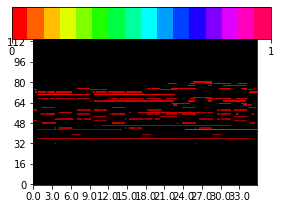

In [17]:
create_midi_file()
mid = MidiFile('midi_files.mid')
roll = mid.get_roll()
mid.draw_roll()

Load pretrained weights

In [18]:
!wget -O musemorphose_pretrained_weights.pt https://zenodo.org/record/5119525/files/musemorphose_pretrained_weights.pt?download=1

--2021-11-07 18:59:21--  https://zenodo.org/record/5119525/files/musemorphose_pretrained_weights.pt?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 359717524 (343M) [application/octet-stream]
Saving to: ‘musemorphose_pretrained_weights.pt’

musemorphose_pretra 100%[===================>] 343.05M  10.4MB/s    in 34s     

2021-11-07 18:59:58 (9.98 MB/s) - ‘musemorphose_pretrained_weights.pt’ saved [359717524/359717524]



In [19]:
!python3 generate.py config/default.yaml musemorphose_pretrained_weights.pt generations/ 1 1

[preparing data] now at #0
[sampled pieces] [19]
[info] writing to ... generations/id19_bar57_orig
generations/id19_bar57_orig.mid
[info] piece: 1341, bar: 57
[info] writing to ... generations/id19_bar57_sample01_poly-2_rhym+1
[info] rhythm cls: tensor([5, 7, 7, 7, 1, 4, 5, 7, 7, 6, 6, 6, 7, 4, 3, 5], device='cuda:0') | polyph_cls: tensor([2, 1, 2, 4, 2, 3, 5, 3, 0, 1, 2, 2, 2, 2, 2, 4], device='cuda:0')
[info] generated 1 bars, #events = 69
[info] generated 2 bars, #events = 148
[info] generated 3 bars, #events = 257
[info] generated 4 bars, #events = 357
[info] generated 5 bars, #events = 397
[info] generated 6 bars, #events = 470
[info] generated 7 bars, #events = 545
[info] generated 8 bars, #events = 628
[info] generated 9 bars, #events = 704
[info] generated 10 bars, #events = 778
[info] generated 11 bars, #events = 854
[info] generated 12 bars, #events = 916
[info] generated 13 bars, #events = 986
[info] reset context length: cur_len: 1024, accumulated_len: 1024, truncate_range: